<a href="https://colab.research.google.com/github/jackcavanaugh/Cahn-Hilliard/blob/main/CahnHilliard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cahn-Hilliard Equation Simulation in Python

This notebook simulates the Cahn-Hilliard equation in two dimensions.

The Cahn-Hilliard equation describes phase separation in binary mixtures, modeling how concentration evolves under free-energy minimization.

The fourth-order derivative accounts for the energetic cost of interface formation and curvature (unlike Fick's laws which only account for second order diffusion).

Here is the general form:

$$
\frac{\partial \phi}{\partial t} = \nabla \cdot \left( M \nabla \mu \right)
$$

where:
- $\phi$ is the concentration field
- $M$ is the mobility (assumed constant or a function of $c$)
- $μ$ is the chemical potential of the system, defined as the functional derivative of free energy with respect to the concentration field. In other words, the chemical potential μ quantifies the sensitivity of the free energy to local variations in the concentration field:
  $$
  μ = \frac{\delta F}{\delta \phi} = f'(\phi) - Κ ∇^2 \phi
  $$
- $\kappa$ is the gradient energy coefficient. It quantifies the energetic cost of spatial variations in concentration, "penalizing" sharp interfaces between phases.

**Simulation Parameters**

We'll define local free energy $f(\phi)$ as a double-well potential with local free energy:

$$
f(\phi) = \frac{A}{4} (\phi^2 - 1)^2.
$$

and barrier height:

$$
A = \frac{3\sigma}{\delta}
$$

Here:
- $\delta$ is the characteristic interface width, indicating the typical thickness over which the concentration changes between phases
- $\sigma$ is the interfacial energy density, representing the energy cost per unit area for forming an interface.

In the simulation we'll scale $A \rightarrow 10A$ to increase the depth of each well.

The gradient energy coeffient $\kappa = \delta^2 A$

The gradient energy term’s coefficient is  K = δ 2 A

The diffusivity  D determines mass transport, and because the curvature of $f(c)$ is  $f′′(c)= 2A$, the mobility is simply:

$$
M = \frac{D}{2A}.
$$

### Materials Parameters

To start, let's set-up imports, model parameters, and folder for saving results.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

# Materials parameters
delta = 10  # nm
sigma = 1.0e-19  # J/nm^2
A = 3 * sigma / delta  # J/nm^3, Height of the barrier between two energy wells
K = delta**2 * A # J/nm
A *= 10  # Need for speed?
D = 1e9  # nm^2/s

# Since d2fdphi2 = 2*A, the mobility M is constant
M = D / (2 * A)

# Come back to this. Only used for plots - is there a more fundamental way to define phases?
conc_min, conc_max = 0, 1

# Review Materials Properties

Before running the simulation, let's gain some basic understanding of the materials system.

For example, the free energy functional can also be recovered from the functional derivative (using integration by parts):

$$
F[\phi] = \int \left( f(\phi) + \frac{K}{2} |\nabla \phi|^2 \right) \, dV
$$

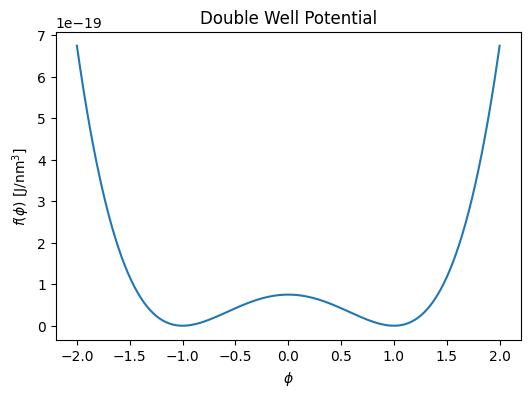

In [42]:
# Define the double well potential function
def f(phi):
    return A / 4 * (phi**2 - 1)**2

# Create a range of phi values
phi = np.linspace(-2, 2, 400)
f_phi = f(phi)

# Plot the function
plt.figure(figsize=(6,4))
plt.plot(phi, f_phi, label='Double Well Potential')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$f(\phi)$ [J/nm$^3$]')
plt.title('Double Well Potential');


### Define Cahn-Hilliard equation

In [43]:
# Define the Laplacian using periodic boundary conditions
def laplacian(u, h):
    return (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
            np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) - 4*u) / h**2

## Experiment 1

### Initial Condition & Time Settings

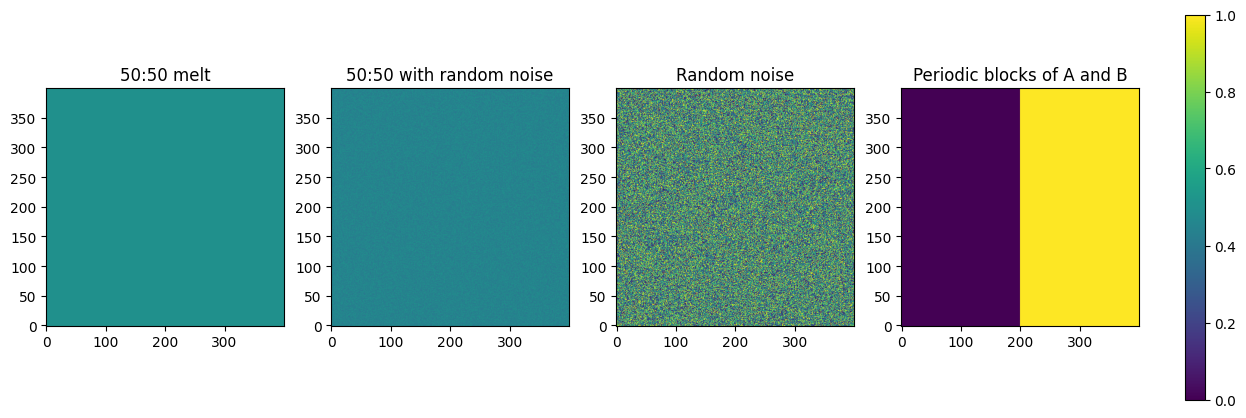

In [44]:
# Mesh grid
h = 1  # spacing, nm
N = 200  # Mesh size

# Plot Initial Condition

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# System 1: 50:50 melt
System_01 = np.full((N, N), 0.5)
im = axs[0].imshow(System_01, origin='lower', cmap='viridis', vmin=conc_min, vmax=conc_max)
axs[0].set_title('50:50 melt')

# System 2: 50:50 melt with random noise
System_02 = 0.5 - 0.1*np.random.rand(N, N)
im = axs[1].imshow(System_02, origin='lower', cmap='viridis', vmin=conc_min, vmax=conc_max)
axs[1].set_title('50:50 with random noise')

# System 3: Random noise
System_03 = np.random.rand(N, N)
im = axs[2].imshow(System_03, origin='lower', cmap='viridis', vmin=conc_min, vmax=conc_max)
axs[2].set_title('Random noise')

# System 4: Periodic blocks of A and B
System_04 = np.full((N, N), 0)
System_04[:, N//2:] = 1
im = axs[3].imshow(System_04, origin='lower', cmap='viridis', vmin=conc_min, vmax=conc_max)
axs[3].set_title('Periodic blocks of A and B')

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04);

In [46]:
System = System_03

# Time settings
t_index = 0
dT = 1e-12
steps = int(1e3)
save_interval = steps/10

### Numerical Simulation

You can run the following simulation multiple times and each sequential run will continue from the end of the previous run.

Simulation complete.


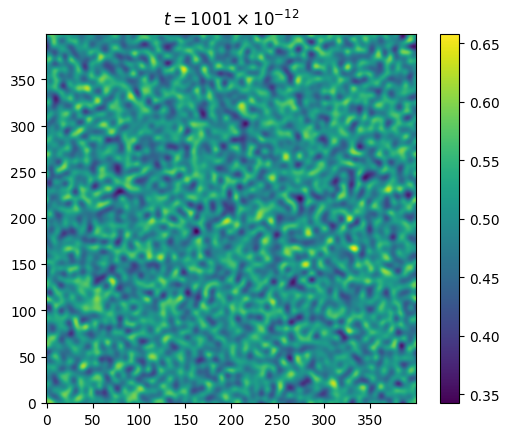

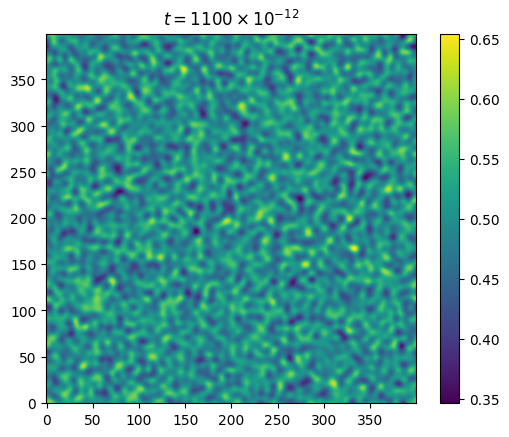

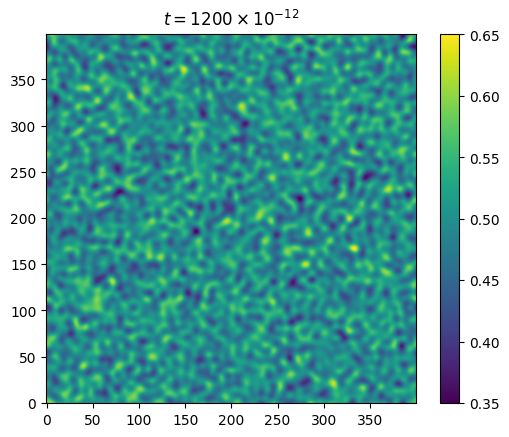

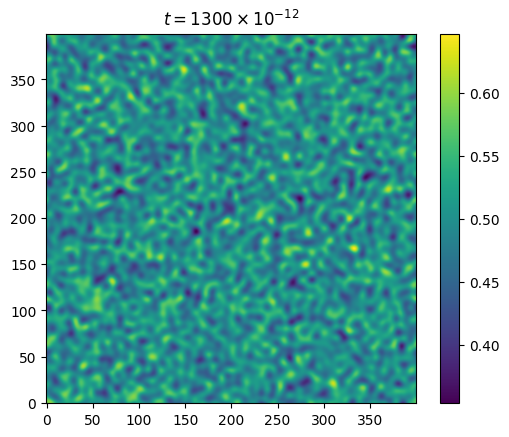

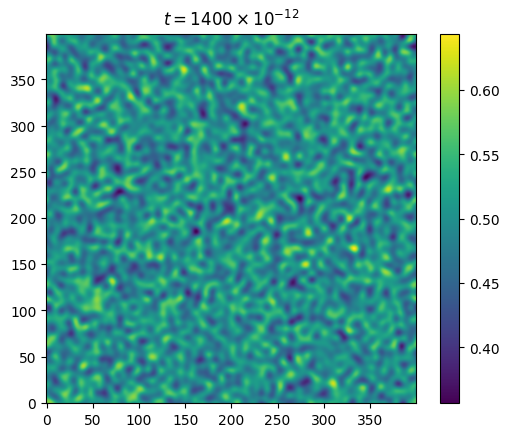

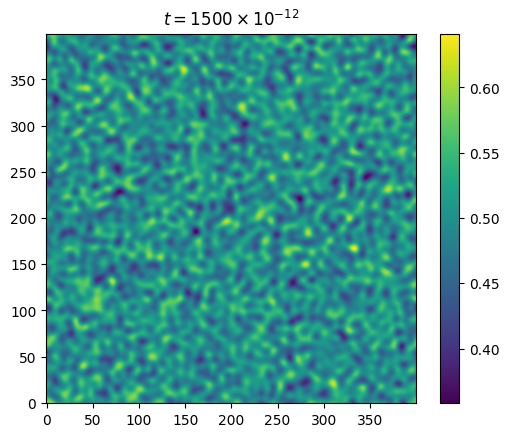

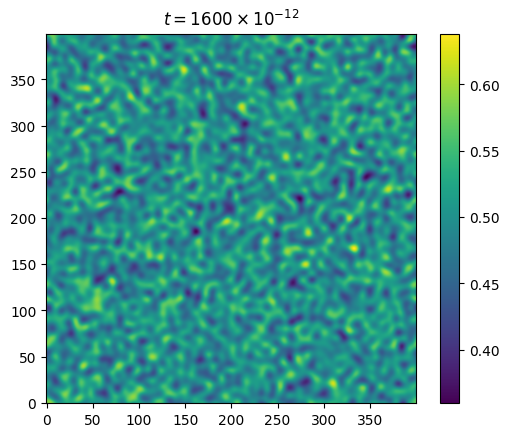

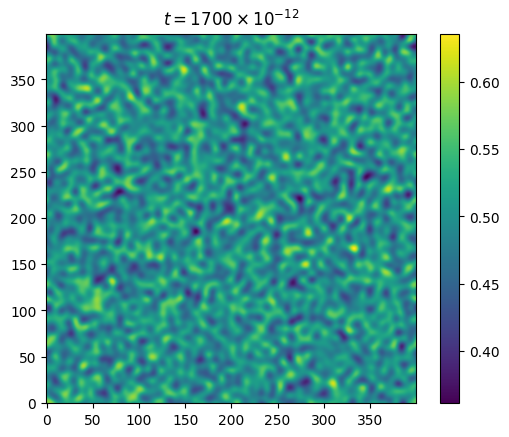

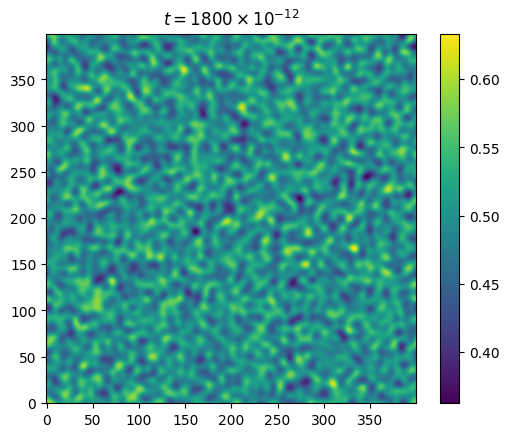

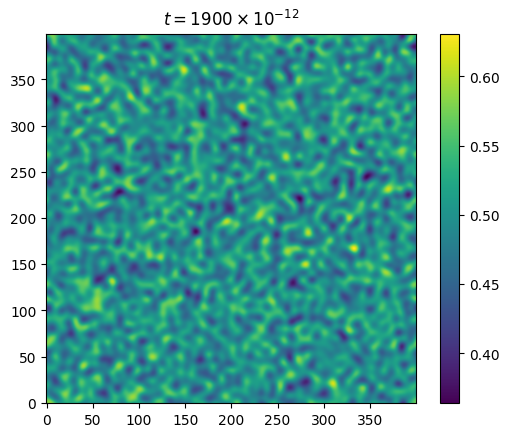

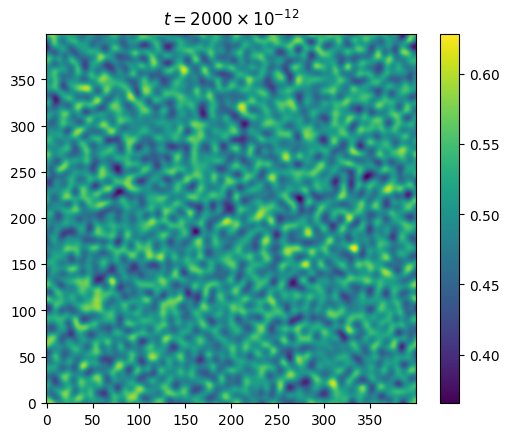

In [48]:
# Maybe interesting for later
# volume_fraction = np.zeros(steps)
# interfacial_area = np.zeros(steps)

for step in range(steps):
    # Compute derivative of free energy
    dfdphi = A * (4 * System**3 - 6 * System**2 + 2 * System)

    # Compute Laplacian of phi
    del2phi = laplacian(System, h)

    # Compute the chemical potential term
    chemical_potential = dfdphi - 2 * K * del2phi

    # Compute the right-hand side
    RHS = M * laplacian(chemical_potential, h)

    # Update phi
    System = System + dT * RHS

    # Record volume fraction and interfacial area
    # volume_fraction[step] = np.sum(System > 0.7) / (N**2)
    # interfacial_area[step] = np.sum(np.logical_and(System > 0.3, System < 0.7))

    # Save condition and plot every save_interval steps
    if step == 0 or (step + 1) % save_interval == 0:
        plt.figure()
        plt.imshow(System, origin='lower', cmap='viridis') #, vmin=conc_min, vmax=conc_max)
        plt.title(r'$t = %d \times 10^{%d}$' % (t_index + 1, int(np.floor(np.log10(dT)))))
        plt.colorbar()

    t_index += 1

step = 0
print('Simulation complete.')